## テーブル定義

In [16]:
import pandas as pd
# 法人テーブル
companies_df = pd.DataFrame({
   'corporate_number': pd.Series(dtype='str'),
   'name': pd.Series(dtype='str'),
   'kana': pd.Series(dtype='str'),
   'name_en': pd.Series(dtype='str'),
   'location': pd.Series(dtype='str'),
   'postal_code': pd.Series(dtype='str'),
   'status': pd.Series(dtype='str'),
   'fiscal_year': pd.Series(dtype='int64'),
   'update_date': pd.Series(dtype='str')
})


# 補助金テーブル
subsidies_df = pd.DataFrame({
    'id': pd.Series(dtype='int64'),
    'corporate_number': pd.Series(dtype='str'),
    'title': pd.Series(dtype='str'),
    'amount': pd.Series(dtype='str'),
    'date_of_approval': pd.Series(dtype='str'),
    'government_departments': pd.Series(dtype='str'),
    'subsidy_resource': pd.Series(dtype='str'),
    'target': pd.Series(dtype='str'),
    'note': pd.Series(dtype='str'),
    'fiscal_year': pd.Series(dtype='int64')
})


# a

In [15]:
import pandas as pd
import aiohttp
import asyncio
import time

# API設定
# API_TOKEN = "YOUR_API_TOKEN"  # トークンを置き換えてください
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"  # テスト後に削除
BASE_URL = "https://info.gbiz.go.jp/hojin"
HEADERS = {"X-hojinInfo-api-token": API_TOKEN}

# DataFrameテンプレート
companies_df = pd.DataFrame({
    'corporate_number': pd.Series(dtype='str'),
    'name': pd.Series(dtype='str'),
    'kana': pd.Series(dtype='str'),
    'name_en': pd.Series(dtype='str'),
    'location': pd.Series(dtype='str'),
    'postal_code': pd.Series(dtype='str'),
    'status': pd.Series(dtype='str'),
    'update_date': pd.Series(dtype='str')
})

subsidies_df = pd.DataFrame({
    'id': pd.Series(dtype='int64'),
    'corporate_number': pd.Series(dtype='str'),
    'title': pd.Series(dtype='str'),
    'amount': pd.Series(dtype='str'),
    'date_of_approval': pd.Series(dtype='str'),
    'government_departments': pd.Series(dtype='str'),
    'subsidy_resource': pd.Series(dtype='str'),
    'target': pd.Series(dtype='str'),
    'note': pd.Series(dtype='str')
})

processed_pages_df = pd.DataFrame({
    'data_type': pd.Series(dtype='str'),
    'page_number': pd.Series(dtype='int64')
})

async def fetch_subsidy_data(session, start_date, end_date, page=1):
    """非同期APIリクエスト - 補助金情報取得"""
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': start_date,
        'to': end_date,
        'page': str(page)
    }
    
    try:
        async with session.get(endpoint, headers=HEADERS, params=params) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"エラー: HTTPステータスコード {response.status}")
                return None
    except Exception as e:
        print(f"リクエストエラー: {e}")
        return None

def save_data_to_df(data):
    """DataFrameにデータを保存"""
    global companies_df, subsidies_df
    
    if not data or "hojin-infos" not in data:
        return 0, 0
    
    companies_count = 0
    subsidies_count = 0
    
    for company in data["hojin-infos"]:
        # 法人情報の保存
        new_company = pd.DataFrame({
            'corporate_number': [company.get("corporate_number", "")],
            'name': [company.get("name", "")],
            'kana': [company.get("kana", "")],
            'name_en': [company.get("name_en", "")],
            'location': [company.get("location", "")],
            'postal_code': [company.get("postal_code", "")],
            'status': [company.get("status", "")],
            'update_date': [company.get("update_date", "")]
        })
        
        companies_df = pd.concat([companies_df, new_company], ignore_index=True)
        companies_count += 1
        
        # 補助金情報の保存
        if "subsidy" in company and company["subsidy"]:
            for subsidy in company["subsidy"]:
                new_subsidy = pd.DataFrame({
                    'id': [len(subsidies_df) + 1],
                    'corporate_number': [company.get("corporate_number", "")],
                    'title': [subsidy.get("title", "")],
                    'amount': [subsidy.get("amount", "")],
                    'date_of_approval': [subsidy.get("date_of_approval", "")],
                    'government_departments': [subsidy.get("government_departments", "")],
                    'subsidy_resource': [subsidy.get("subsidy_resource", "")],
                    'target': [subsidy.get("target", "")],
                    'note': [subsidy.get("note", "")]
                })
                
                subsidies_df = pd.concat([subsidies_df, new_subsidy], ignore_index=True)
                subsidies_count += 1
    
    return companies_count, subsidies_count

def is_page_processed(page):
    """ページが処理済みかチェック"""
    global processed_pages_df
    return not processed_pages_df[
        (processed_pages_df['data_type'] == 'subsidy') & 
        (processed_pages_df['page_number'] == page)
    ].empty

def mark_page_processed(page):
    """ページを処理済みとしてマーク"""
    global processed_pages_df
    new_page = pd.DataFrame({
        'data_type': ['subsidy'],
        'page_number': [page]
    })
    processed_pages_df = pd.concat([processed_pages_df, new_page], ignore_index=True)

async def get_subsidy_data(start_date, end_date):
    """非同期実行で補助金情報を取得"""
    global companies_df, subsidies_df
    
    async with aiohttp.ClientSession() as session:
        # 最初に1ページ目を取得して総ページ数を確認
        initial_data = await fetch_subsidy_data(session, start_date, end_date, 1)
        if not initial_data or "totalPage" not in initial_data:
            print("総ページ数の取得に失敗しました")
            return
        
        total_pages = int(initial_data["totalPage"])
        print(f"補助金情報総ページ数: {total_pages}、期間: {start_date}～{end_date}")
        
        # 1ページ目の処理
        if not is_page_processed(1):
            companies, subsidies = save_data_to_df(initial_data)
            mark_page_processed(1)
            print(f"ページ 1: {companies}社の情報と{subsidies}件の補助金情報を保存")
        else:
            print("ページ 1は処理済みです")
        
        # 残りのページを10ページずつバッチ処理
        start_time = time.time()
        processed_pages = 1
        
        for start_page in range(2, total_pages + 1, 10):
            batch_tasks = []
            batch_pages = []
            
            for page in range(start_page, min(start_page + 10, total_pages + 1)):
                if not is_page_processed(page):
                    batch_tasks.append(fetch_subsidy_data(session, start_date, end_date, page))
                    batch_pages.append(page)
                else:
                    print(f"ページ {page} は処理済みです")
            
            if batch_tasks:
                print(f"バッチ取得: {len(batch_tasks)} ページ")
                results = await asyncio.gather(*batch_tasks)
                
                for i, result in enumerate(results):
                    page = batch_pages[i]
                    if result:
                        companies, subsidies = save_data_to_df(result)
                        mark_page_processed(page)
                        processed_pages += 1
                        
                        # 進捗表示
                        elapsed_time = time.time() - start_time
                        avg_time_per_page = elapsed_time / processed_pages if processed_pages > 0 else 0
                        remaining_pages = total_pages - processed_pages
                        est_remaining_time = avg_time_per_page * remaining_pages
                        
                        print(f"ページ {page}/{total_pages}: {companies}社, {subsidies}件 " +
                              f"(進捗: {processed_pages/total_pages*100:.1f}%, 残り約{est_remaining_time/60:.1f}分)")
                
                await asyncio.sleep(1)  # APIレート制限対策
    
    # 最終結果の表示
    elapsed_time = time.time() - start_time
    print(f"\n処理完了 ({elapsed_time/60:.1f}分)")
    print(f"データには{len(companies_df)}社の法人情報と{len(subsidies_df)}件の補助金情報があります")

def main():
    # データ取得期間を直接指定
    start_date = "20200401"
    end_date = "20210331"
    
    # データ取得実行
    asyncio.run(get_subsidy_data(start_date, end_date))
    
    # データセット保存
    companies_df.to_csv('companies_2020.csv', index=False)
    subsidies_df.to_csv('subsidies_2020.csv', index=False)
    
    # データ概要表示
    print("\n法人データ概要:")
    print(companies_df.info())
    
    print("\n補助金データ概要:")
    print(subsidies_df.info())

if __name__ == "__main__":
    main()

補助金情報総ページ数: 919、期間: 20200401～20210331
ページ 1: 40社の情報と100件の補助金情報を保存
バッチ取得: 10 ページ
ページ 2/919: 21社, 100件 (進捗: 0.2%, 残り約13.0分)
ページ 3/919: 16社, 100件 (進捗: 0.3%, 残り約8.8分)
ページ 4/919: 13社, 100件 (進捗: 0.4%, 残り約6.7分)
ページ 5/919: 18社, 100件 (進捗: 0.5%, 残り約5.4分)
ページ 6/919: 30社, 100件 (進捗: 0.7%, 残り約4.6分)
ページ 7/919: 75社, 100件 (進捗: 0.8%, 残り約4.0分)
ページ 8/919: 26社, 100件 (進捗: 0.9%, 残り約3.5分)
ページ 9/919: 27社, 100件 (進捗: 1.0%, 残り約3.2分)
ページ 10/919: 18社, 100件 (進捗: 1.1%, 残り約2.9分)
ページ 11/919: 57社, 100件 (進捗: 1.2%, 残り約2.7分)
バッチ取得: 10 ページ
ページ 12/919: 34社, 100件 (進捗: 1.3%, 残り約5.9分)
ページ 13/919: 49社, 100件 (進捗: 1.4%, 残り約5.5分)
ページ 14/919: 19社, 100件 (進捗: 1.5%, 残り約5.1分)
ページ 15/919: 39社, 100件 (進捗: 1.6%, 残り約4.8分)
ページ 16/919: 66社, 100件 (進捗: 1.7%, 残り約4.5分)
ページ 17/919: 47社, 100件 (進捗: 1.8%, 残り約4.3分)
ページ 18/919: 47社, 100件 (進捗: 2.0%, 残り約4.1分)
ページ 19/919: 51社, 100件 (進捗: 2.1%, 残り約3.9分)
ページ 20/919: 84社, 100件 (進捗: 2.2%, 残り約3.7分)
ページ 21/919: 67社, 100件 (進捗: 2.3%, 残り約3.6分)
バッチ取得: 10 ページ
ページ 22/919: 58社, 100件 (進捗: 2.4%, 残り約5.5分)
ページ 23/919: 41社, 

/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_97354/707882880.py:14: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  subsidies_df = pd.read_csv(subsidies_file)


既存のCSVファイルからデータを読み込みました。


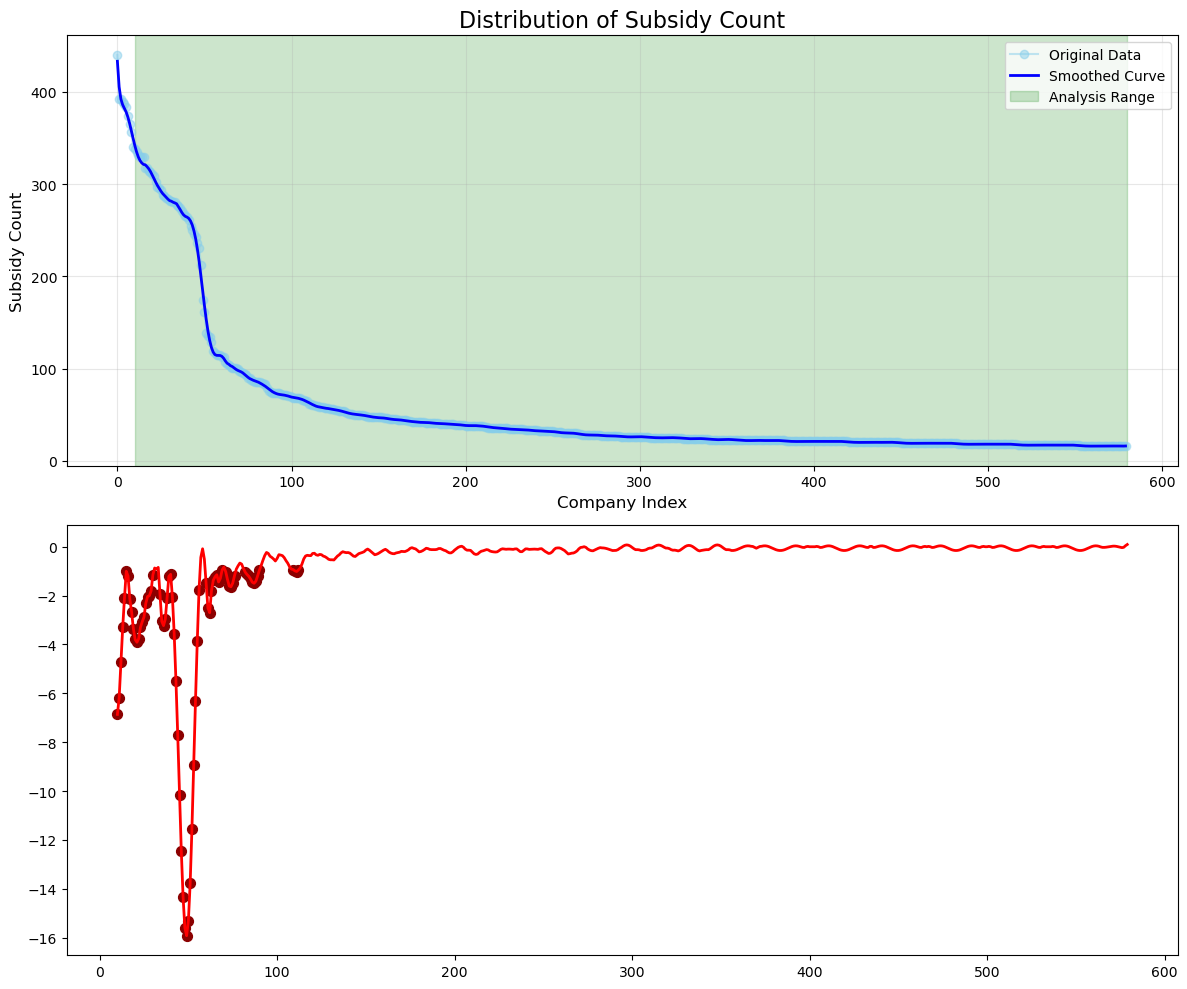

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os

def load_dataset(year):
    """データセットを読み込む"""
    companies_file = f'companies_{year}.csv'
    subsidies_file = f'subsidies_{year}.csv'
    
    if os.path.exists(companies_file) and os.path.exists(subsidies_file):
        companies_df = pd.read_csv(companies_file)
        subsidies_df = pd.read_csv(subsidies_file)
        print("既存のCSVファイルからデータを読み込みました。")
        return companies_df, subsidies_df
    else:
        print("CSVファイルが見つかりません。データ取得が必要です。")
        return None, None

def analyze_subsidies(subsidies_df):
    """補助金データの分析"""
    # 企業ごとの補助金データを集計
    company_counts_df = subsidies_df.groupby('corporate_number').agg({
        'title': 'count',
        'amount': lambda x: pd.to_numeric(x.apply(lambda val: str(val).replace(',', '')), errors='coerce').sum(),
        'government_departments': 'nunique'
    }).rename(columns={
        'title': 'subsidy_count', 
        'amount': 'total_amount'
    }).sort_values('subsidy_count', ascending=False)
    
    return company_counts_df

def subsidy_trend_analysis(df, variable='subsidy_count', window_size=31, polyorder=7, skip_initial=10):
    """補助金トレンド分析"""
    subsidy_counts = df[variable].values
    x = np.arange(len(subsidy_counts))
    
    # グラフ作成
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(x, subsidy_counts, 'o-', color='skyblue', alpha=0.5, label='Original Data')
    
    smoothed = savgol_filter(subsidy_counts, window_size, polyorder)
    ax1.plot(x, smoothed, '-', color='blue', linewidth=2, label='Smoothed Curve')
    
    ax1.axvspan(skip_initial, len(x), alpha=0.2, color='green', label='Analysis Range')
    
    ax1.set_title('Distribution of Subsidy Count', fontsize=16)
    ax1.set_xlabel('Company Index', fontsize=12)
    ax1.set_ylabel('Subsidy Count', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 微分計算
    x_limited = x[skip_initial:]
    smoothed_limited = smoothed[skip_initial:]
    derivatives = np.gradient(smoothed_limited)
    
    ax2.plot(x_limited, derivatives, '-', color='red', linewidth=2)
    
    # 重要な変化点の検出
    threshold = np.std(derivatives) * 0.5
    significant_changes = np.where(np.abs(derivatives) > threshold)[0]
    
    ax2.scatter(x_limited[significant_changes], derivatives[significant_changes], 
               color='darkred', s=50, label='Significant Change Points')
    
    plt.tight_layout()
    plt.show()

def main():
    year = 2020
    companies_df, subsidies_df = load_dataset(year)
    
    if subsidies_df is not None:
        company_counts_df = analyze_subsidies(subsidies_df)
        subsidy_trend_analysis(company_counts_df.head(580))

if __name__ == "__main__":
    main()